In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import pathlib
from random import choice, seed, randrange

In [2]:
# Đường dẫn ảnh gốc
root = 'leedsbutterfly/images'
# Đường dẫn segmentations gốc
root_seg = 'leedsbutterfly/segmentations/'

# Lấy ảnh ngẫu nhiên trong tập train và gán nhãn
def take_random_img_label():
    paths = list(Path(root).rglob('*.png'))
    path = choice(paths)
    img = cv2.imread(path.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(path)
    label = pathlib.PurePath(path).name[0:3]
    return img, label

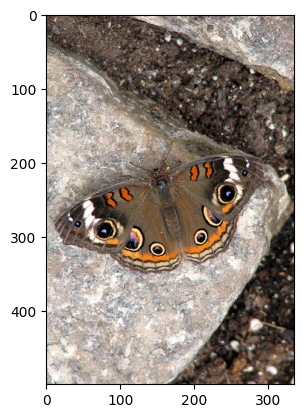

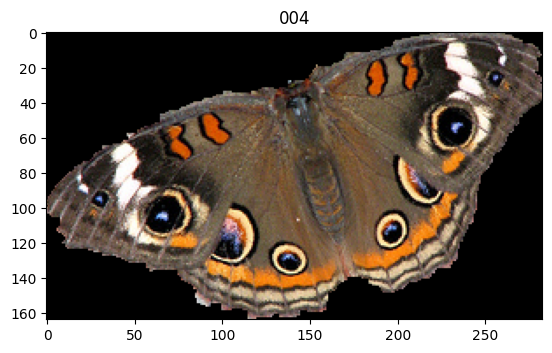

In [3]:
# Lấy ảnh ngẫu nhiên và cắt
paths = list(Path(root).rglob('*.png'))
path = choice(paths)

img = Image.open(path)
plt.imshow(img)
plt.show()
seg = Image.open(root_seg + pathlib.PurePath(path).name[:-4] + '_seg0.png')
seg_arr = np.array(seg)
seg_arr = np.where(seg_arr==1, seg_arr, 0)  # Unnecessary since we converted the image to mode 1 above

img_masked = Image.new("RGB", img.size)
img_masked.paste(img, mask=seg.convert("1"))

# Find the segmentation mask bounds
bounds = np.nonzero(seg_arr)
bbox = (bounds[1].min(), bounds[0].min(), bounds[1].max(), bounds[0].max())

# Crop to the segmentation mask bounds
img_masked_crp = img_masked.crop(bbox)
seg_crp = seg.crop(bbox)
label = pathlib.PurePath(path).name[0:3]
plt.imshow(img_masked_crp)
plt.title(label)
plt.show()

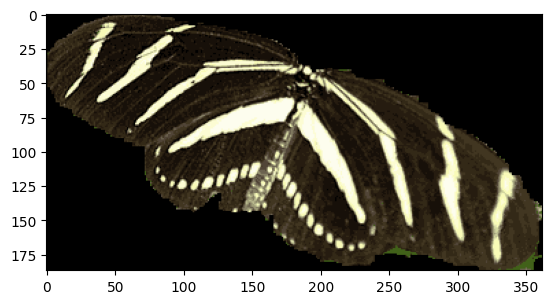

In [4]:
img_masked_crp = np.array(img_masked_crp)

# Dùng Kmeans để Quantizaion
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = img_masked_crp.reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

#the below line of code defines the criteria for the algorithm to stop running, 
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 16
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((img_masked_crp.shape))
 
plt.imshow(segmented_image)
plt.show()

In [5]:
# tinh histogram cua kenh H tu anh 
def hsv_histogram(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0]
    return np.bincount(h.ravel(), minlength=256)

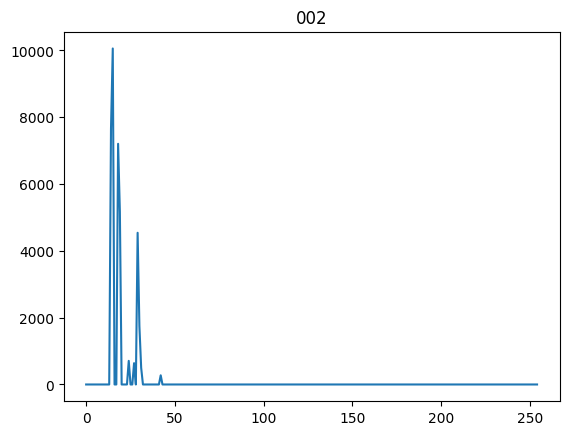

In [6]:
hist = hsv_histogram(segmented_image)
plt.plot(hist[1:])
plt.title(label)
plt.show()

### Feature extraction

In [7]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [9]:
# mảng lưu trữ features
df = pd.DataFrame(columns=[i for i in range(255)])
col_labels = []

In [10]:
k = 16

# Tính vector histogram cho tất cả các ảnh
for i, path in enumerate(paths):
    img = Image.open(path)
    seg = Image.open(root_seg + pathlib.PurePath(path).name[:-4] + '_seg0.png')
    seg_arr = np.array(seg)
    seg_arr = np.where(seg_arr==1, seg_arr, 0)  # Unnecessary since we converted the image to mode 1 above

    img_masked = Image.new("RGB", img.size)
    img_masked.paste(img, mask=seg.convert("1"))

    # Find the segmentation mask bounds
    bounds = np.nonzero(seg_arr)
    bbox = (bounds[1].min(), bounds[0].min(), bounds[1].max(), bounds[0].max())

    # Crop to the segmentation mask bounds
    img_masked_crp = img_masked.crop(bbox)
    seg_crp = seg.crop(bbox)
    label = pathlib.PurePath(path).name[0:3]
    col_labels.append(label) # append labels to insert after the loop

    img_masked_crp = np.array(img_masked_crp)
    # Dùng Kmeans để Quantizaion
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    pixel_vals = img_masked_crp.reshape((-1,3))
    
    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    #the below line of code defines the criteria for the algorithm to stop running, 
    #which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
    #becomes 85%
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((img_masked_crp.shape))

    hist = hsv_histogram(segmented_image)
    df = pd.concat([df, pd.DataFrame(hist[1:]).T], ignore_index=True)
    
df['labels'] = col_labels # thêm nhãn vào dữ liệu

In [16]:
PATCH_IM_RGB_IDX = 0
PATCH_AR_R_IDX = 1  # Start arrays at index 1 so they can map directly onto NM500 contexts, which start at 1
PATCH_AR_G_IDX = 2
PATCH_AR_B_IDX = 3
PATCH_AR_Y_IDX = 4
PATCH_AR_CR_IDX = 5
PATCH_AR_CB_IDX = 6
PATCH_AR_S_IDX, NUM_CONTEXT_TYPES = 7, 7  # Make sure NUM_CONTEXT_TYPES is moved down here if new types are added after saturation
PATCH_IM_R_IDX = 8
PATCH_IM_G_IDX = 9
PATCH_IM_B_IDX = 10
PATCH_IM_Y_IDX = 11
PATCH_IM_CR_IDX = 12
PATCH_IM_CB_IDX = 13
PATCH_IM_S_IDX = 14
PATCH_BBUL_IDX = 15

def generate_one_patch_bbox(patch_wh, search_bounds_w, search_bounds_h, dead_zone_centers, dead_zone_size, deadzone_max_attempts):
    '''
    Generate the bounding box coordinates of a random 16x16 square within the bounds of a given image subject to restriction that a new bbox is not permitted to overlap a previously generated bbox too closely.
    The goal is to space out the random sampling of patches to loosely cover an image without too much crowding.
    
    Parameters:
        patch_wh (int): Dimensions of a patch (this is always 16).
        search_bounds_w, search_bounds_h (int): The dimensions of the image for which to produce a new bbox.
        dead_zone_centers (list of 2-tuples): List of upper-left coordinates of previously generated patches. The bbox generated during this call may not have an UL corner closer than dead_zone_size pixels from any dead_zone coordinate.
        dead_zone_size (int): Cardinal radius of exclusion around a dead_zone_center in which the UL corner of the next bbox may not reside.
        deadzone_max_attempts (int): Maximum number of attempts to make to find a bbox that doesn't violate a dead zone before giving up, presumably on the basis that the image is too small to support the requested number of patches relative to the patch-spacing restrictions.
    '''
    num_deadzone_attempts = 0
    while True:
        bbox_l = randrange(search_bounds_w) if search_bounds_w > 0 else 0
        bbox_t = randrange(search_bounds_h) if search_bounds_h > 0 else 0
        bbox_r = bbox_l + patch_wh
        bbox_b = bbox_t + patch_wh
        bbox = (bbox_l, bbox_t, bbox_r, bbox_b)

        dead = False
        for dead_zone_center in dead_zone_centers:
            if bbox_l >= dead_zone_center[0] - dead_zone_size and bbox_t >= dead_zone_center[1] - dead_zone_size and bbox_l <= dead_zone_center[0] + dead_zone_size and bbox_t <= dead_zone_center[1] + dead_zone_size:
                dead = True
                break
        if not dead:
            return bbox
        num_deadzone_attempts += 1
        if num_deadzone_attempts > deadzone_max_attempts:
            break
    return None

In [17]:
def generate_one_image_patches(img, seg, draw, patch_wh, patch_npxs, patch_min_coverage, num_good_patches_goal, dead_zone_centers, dead_zone_size, coverage_max_attempts, deadzone_max_attempts, transform=False, verbose_level=0):
    '''
    Given an image and its segmentation mask, generate a set of randomly sampled patches, where a patch is a small section of the image.
    For this experiment, patches are always 16x16 pixels, but that isn't a hard requirement. The only restriction is the 256-byte capacity of an NM500 pattern.
    So, for example, patches could be 32x8 pixels or any other shape that holds no more than 256 pixels.
    
    Although patches are sampled at random from the bounds of the image, there are various restrictions that can result in their disposal.
    One restriction is that patches may not overlap one another too closely. This restriction increases the likelihood that randomly sample patches will give a decent coverage of the image with minimal crowding.
    Another restriction is, given the segmentation mask of the butterfly within the image, we can exploit that a priori information to optimize our patch generation to exclude patch bounds that fall outside the segmentation mask or which fall on the border of the mask and do not include a sufficient proportion of mask pixels.
    
    For each satisfactory patch, optionally (as per a boolean parameter) generate transforms of the patch (rotations and reflections) to allow the patch to be queried against a trained network in various orientations.
    Convert each RGB patch into a set of single-band grayscale images representing various dimensional slices through the colorspace. I have currently provided red, green, blue, Y, Cr, Cb, and saturation.
    
    I didn't bother using value since that seem conceptually fairly similar to Y (luminance) and I didn't bother with hue
    because it is virtually impossible to map a circular variable such as hue onto a scalar differentiator such as the NM500's pattern difference comparator
    (which scores a neuron's pattern against a queried pattern as the summed element-wise difference between the two patterns).
    
    Parameters:
        img (PIL.Image, mode RGB)
        seg (PIL.Image, mode L)
        draw (PIL.ImageDraw)
        patch_wh (int): Dimensions of a patch (this is always 16).
        patch_npxs (int)
        patch_min_coverage (float, 0.0-1.0): Proportion of a patch which must cover the segmentation mask
        num_good_patches_goal (int): The number of patches to attempt to generate. If the image is too small relative to the spacing requirements, it may not be possible to generate this many patches.
        dead_zone_centers: see generate_one_patch_bbox()
        dead_zone_size: see generate_one_patch_bbox()
        coverage_max_attempts (int): Maximum number of attempts to make to find a bbox with sufficient coverage of the segmentation mask before giving up, presumably on the basis that the image is too small to support the requested number of patches relative to the patch-spacing restrictions.
        deadzone_max_attempts: see generate_one_patch_bbox()
        transform (bool): Indicates that a patch should be converted into multiple rotations and reflections and returned as a set of corresponding patches.
    '''
    num_good_coverage_attempts = 0
    n_good_patches = 0
    patches = []
    search_bounds_w, search_bounds_h = img.size[0] - patch_wh, img.size[1] - patch_wh
    if search_bounds_w < 0 or search_bounds_h < 0:
        raise ValueError("Negative search bounds: {} {} {} {}".format(img.size, patch_wh, search_bounds_w, search_bounds_h))
    while n_good_patches < num_good_patches_goal:
        bbox = generate_one_patch_bbox(patch_wh, search_bounds_w, search_bounds_h, dead_zone_centers, dead_zone_size, deadzone_max_attempts)
        if bbox is None:
            if verbose_level >= 2:
                print("Could not find suitable bbox")
            break

        num_black_pxs = sum(seg.crop(bbox)
                       .point(lambda x: 1 if x else 0)
                       .convert("L")
                       .point(bool)
                       .getdata())

        good_seg_overlap = num_black_pxs >= patch_npxs * patch_min_coverage

        if draw:
            red = (255 - num_black_pxs) if not good_seg_overlap else 0
            green = (num_black_pxs - 1) if good_seg_overlap else 0
            color = (0xa0 << 24) | (0x00 << 16) | (green << 8) | red
            draw.rectangle((bbox[0], bbox[1], bbox[2] - 1, bbox[3] - 1), None, color, 1)

        if good_seg_overlap:
            n_good_patches += 1
            dead_zone = (bbox[0] - dead_zone_size, bbox[1] - dead_zone_size, bbox[0] + dead_zone_size, bbox[1] + dead_zone_size)
            dead_zone_centers.add((bbox[0], bbox[1]))

            patch_transforms = [
                img.crop(bbox)
            ]
            if transform:
                # TODO: It would probably be faster to perform the transforms on the numpy array (see below) than on the PIL image
                patch = patch_transforms[0]
                patch_transforms.extend([
                    patch.transpose(Image.ROTATE_90),
                    patch.transpose(Image.ROTATE_180),
                    patch.transpose(Image.ROTATE_270),
                    patch.transpose(Image.FLIP_LEFT_RIGHT),
                    patch.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.ROTATE_90),
                    patch.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.ROTATE_180),
                    patch.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.ROTATE_270),
                ])
            
            for patch in patch_transforms:
                aRGB = np.array(patch)
                aYCC = cv2.cvtColor(aRGB, cv2.COLOR_RGB2YCR_CB)
                aHSV = cv2.cvtColor(aRGB, cv2.COLOR_RGB2HSV)
                if False:#imi % 10 == 0:
                    print("RGB/YCC min/max:    {:>3} {:>3}    {:>3} {:>3}    {:>3} {:>3}        {:>3} {:>3}    {:>3} {:>3}    {:>3} {:>3}        {:>3} {:>3}    {:>3} {:>3}    {:>3} {:>3}".format( \
                        aRGB[:,:,0].min(), aRGB[:,:,0].max(), aRGB[:,:,1].min(), aRGB[:,:,1].max(), aRGB[:,:,2].min(), aRGB[:,:,2].max(),
                        aYCC[:,:,0].min(), aYCC[:,:,0].max(), aYCC[:,:,1].min(), aYCC[:,:,1].max(), aYCC[:,:,2].min(), aYCC[:,:,2].max(),
                        aHSV[:,:,0].min(), aHSV[:,:,0].max(), aHSV[:,:,1].min(), aHSV[:,:,1].max(), aHSV[:,:,2].min(), aHSV[:,:,2].max()))
                imR, imG, imB, imY, imCr, imCb, imS = None, None, None, None, None, None, None
                if draw:
                    imR =  Image.fromarray(np.asarray(aRGB[:,:,0], dtype=np.uint8))
                    imG  = Image.fromarray(np.asarray(aRGB[:,:,1], dtype=np.uint8))
                    imB  = Image.fromarray(np.asarray(aRGB[:,:,2], dtype=np.uint8))
                    imY =  Image.fromarray(np.asarray(aYCC[:,:,0], dtype=np.uint8))
                    imCr = Image.fromarray(np.asarray(aYCC[:,:,1], dtype=np.uint8))
                    imCb = Image.fromarray(np.asarray(aYCC[:,:,2], dtype=np.uint8))
                    imS =  Image.fromarray(np.asarray(aHSV[:,:,1], dtype=np.uint8))
                patches.append((patch,
                                aRGB[:,:,0].flatten(), aRGB[:,:,1].flatten(), aRGB[:,:,2].flatten(),
                                aYCC[:,:,0].flatten(), aYCC[:,:,1].flatten(), aYCC[:,:,2].flatten(),
                                aHSV[:,:,1].flatten(),
                                imR, imG, imB,
                                imY, imCr, imCb,
                                imS,
                                (bbox[0], bbox[1])))

        num_good_coverage_attempts += 1
        if num_good_coverage_attempts >= coverage_max_attempts:
            if verbose_level >= 2:
                print("Max bbox patch attempts reached")
            break
    
    if verbose_level >= 2:
        print("Num coverage attempts, max permitted attempts: {:>3} {} {}".format(num_good_coverage_attempts, coverage_max_attempts, "" if num_good_coverage_attempts < coverage_max_attempts else "MAX ATTEMPTS REACHED!"))
        if n_good_patches != num_good_patches_goal:
            print("Num patches, goal: {:>3} {:>3} {:>3} {:>3} {}".format(n_good_patches, num_good_patches_goal, len(patches), num_good_patches_goal * (8 if transform else 1), "" if len(patches) < num_good_patches_goal * (8 if transform else 1) else "COULD NOT ACHIEVE PATCH NUM GOAL!"))
    
    return patches, dead_zone_centers

In [ ]:
patches, dead_zone_centers = generate_one_image_patches()

In [ ]:
def load_data(patch_wh=16, verbose_level=0):
    np.set_printoptions(edgeitems=10, linewidth=1000)

    project_dirpath = "leedsbutterfly/"
    ori_descriptions_dirpath = project_dirpath + "descriptions/"
    ori_images_dirpath = project_dirpath + "images/"
    ori_segmentations_dirpath = project_dirpath + "segmentations/"

    ori_image_filenames = os.listdir(ori_images_dirpath)
    ori_image_filenames = [file for file in ori_image_filenames if file[-3:] == 'png']
    ori_image_filenames = sorted(ori_image_filenames)

    ori_segmentation_filenames = os.listdir(ori_segmentations_dirpath)
    ori_segmentation_filenames = [file for file in ori_segmentation_filenames if file[-3:] == 'png']
    ori_segmentation_filenames = sorted(ori_segmentation_filenames)

    n_imgs_read = 0
    categorized_imgs = {}
    categories = set()
    w_min, h_min = 99999, 99999
    prev_cat = None
    for fni, fn in enumerate(ori_image_filenames):
        category = int(fn[1:3])

        new_cat = False
        if prev_cat is None or category != prev_cat:
            new_cat = True
            print("Image {:>3} of {}, Category: {}".format(fni, len(ori_image_filenames), category))
        prev_cat = category

        categories.add(category)

        num = int(fn[4:7])
        img = Image.open(ori_images_dirpath + fn)
        n_imgs_read += 1
        seg_fn = fn.replace(".png", "_seg0.png")
        seg = Image.open(ori_segmentations_dirpath + seg_fn)
        seg_arr = np.array(seg)
        seg_arr = np.where(seg_arr==1, seg_arr, 0)  # Unnecessary since we converted the image to mode 1 above

        img_masked = Image.new("RGB", img.size)
        img_masked.paste(img, mask=seg.convert("1"))

        # Find the segmentation mask bounds
        bounds = np.nonzero(seg_arr)
        bbox = (bounds[1].min(), bounds[0].min(), bounds[1].max(), bounds[0].max())

        # Crop to the segmentation mask bounds
        img_masked_crp = img_masked.crop(bbox)
        seg_crp = seg.crop(bbox)

        # The next step is to rotate the image to normalize it to a axis-aligned cardinal alignment (i.e., make the butterfly point straight up).
        # Some of the butterlies will end up pointing downwards, left, or right, but most align the correct way.
        # Somehow fixing the few erroneous alignments might have improved classification performance of course. 
        # There will be at least one mask pixel on each edge of the cropped segmentation.
        # For each edge, find the center pixel.
        # Use the pair of center pixels on opposing edges as an indication of the current rotation of the butterfly and rotate the image to normalize that pair to a horizontal (or vertical) alignment.
        seg_crp_arr = np.array(seg_crp)
        h, w = seg_crp_arr.shape
        l_pxs, r_pxs, t_pxs, b_pxs = set(), set(), set(), set()
        for y in range(seg_crp_arr.shape[0]):
            if seg_crp_arr[y][0]:
                l_pxs.add(y)
            if seg_crp_arr[y][-1]:
                r_pxs.add(y)
        for x in range(seg_crp_arr.shape[1]):
            if seg_crp_arr[0][x]:
                t_pxs.add(x)
            if seg_crp_arr[-1][x]:
                b_pxs.add(x)

        l_pxs = sorted(l_pxs)
        r_pxs = sorted(r_pxs)
        t_pxs = sorted(t_pxs)
        b_pxs = sorted(b_pxs)

        l_mid = l_pxs[0] + (l_pxs[-1] - l_pxs[0]) // 2
        r_mid = r_pxs[0] + (r_pxs[-1] - r_pxs[0]) // 2
        t_mid = t_pxs[0] + (t_pxs[-1] - t_pxs[0]) // 2
        b_mid = b_pxs[0] + (b_pxs[-1] - b_pxs[0]) // 2

        hor_dif = l_mid - r_mid
        ver_dif = t_mid - b_mid

        hor_dist = math.sqrt((l_mid - r_mid)**2 + w**2)
        ver_dist = math.sqrt((t_mid - b_mid)**2 + h**2)

        if hor_dist > ver_dist:
            hor_ang = math.atan2(hor_dif, w)
            img_masked_crp_rot = img_masked_crp
            seg_crp_rot = seg_crp
        else:
            ver_ang = math.atan2(h, ver_dif)
            img_masked_crp_rot = img_masked_crp
            seg_crp_rot = seg_crp
            
        # Find the segmentation mask bounds
        bounds = np.nonzero(seg_crp_rot)
        bbox = (bounds[1].min(), bounds[0].min(), bounds[1].max(), bounds[0].max())

        # Crop to the segmentation mask bounds
        img_masked_crp_rot_crp = img_masked_crp_rot.crop(bbox)
        seg_crp_rot_crp = seg_crp_rot.crop(bbox)

        # Normalize the size
        scale_w, scale_h = 64 / w, 64 / h
        scale = min(scale_w, scale_h)
        w_scaled = round(w * scale)
        h_scaled = round(h * scale)
        if w_scaled < patch_wh or h_scaled < patch_wh:
            print("WARNING! Cropped, rotated, cropped, resized image is thinner or shorter than the patch dimension: {}x{} < {}".format(w_scaled, h_scaled, patch_wh))
            scale =  patch_wh / min(w, h)
            w_scaled = round(w * scale)
            h_scaled = round(h * scale)
            print("Compensated image resize: {}x{}".format(w_scaled, h_scaled))
        w, h = w_scaled, h_scaled
        img_masked_crp_rot_crp_rsz = img_masked_crp_rot_crp.resize((w, h), Image.LANCZOS)
        if img_masked_crp_rot_crp_rsz.size[0] < patch_wh or img_masked_crp_rot_crp_rsz.size[1] < patch_wh:
            raise ValueError("Image is too small: {}".format(img_masked_crp_rot_crp_rsz.size()))
        seg_crp_rot_crp_rsz = seg_crp_rot_crp.resize((w, h))

        if category not in categorized_imgs:
            categorized_imgs[category] = []
        categorized_imgs[category].append((img_masked_crp_rot_crp_rsz, seg_crp_rot_crp_rsz))

        if verbose_level >= 2 or (verbose_level >= 1 and new_cat):
            display_img_row([img_masked_crp_rot_crp_rsz, seg_crp_rot_crp_rsz], bg_color=0xffffff, border=1, scale=4)

    categories = sorted(list(categories))
    
    print("Total images read: {}".format(n_imgs_read))  # len(imgs)))
    print("All categories: {}".format(categories))
    
    return categories, categorized_imgs